Reinforcement learning is one of the most exciting fields in Machine Learning. It is one of the oldest, starting in 1950s, but took in 2013 when a British startup called DeepMind played many Atari games from scratch and beating humans. It later was responsible for beating the Go champion, a landmark moment in the world of machine learning. DeepMind applied Deep Learning to the field of Reinforcement Learning and it worked beyond imgination.

This notebook look is a brief overview of key concepts and ideas in Reinforcement learning, for further reading check [this](http://www.incompleteideas.net/book/the-book-2nd.html) book out for a detailed Introduction. 

### Optimizing Rewards 

In RL, an **agent** makes **observations** and takes **actions** within an **environment** which results in **rewards**. The aim of the agent is to maximize rewards (i.e. max pleasure and min pain). The agent learns how to act in the environment through trial and error to maximize rewards. 

# Policy Search



The algorithm used to determine which action the software agent takes is called its Policy. Think of it has a neural network where the input are rewards and observations and the output are actions to take; although, it can be any algorithm or even a probability.

In order to obtain the best algorithm we need to try many different values for the policy parameters (think of grid search), but this can often be extremely large - i.e. the **policy space**. Alternatively, we could search using **genetic algorithms**, where the best algorithms produce offspring to find policy parameters that are composed of parts of the best parameters.

WAIT! In order for us to train the policy, we first need to create the environment that it sits in! That's where the module `gym` comes in.


### OpenAI Gym

One of the biggest challenges with RL is creating the environment that the agent sits in. For 3D physics simulations, you can use `PyBullet` and `MuJoCo`. A popular toolkit is `OpenAI`, it provides a wide variety of simulated environments such as Atari games, Board game, 2D and 3D simulations and more! 

In [ ]:
!!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
%pip install -U pyvirtualdisplay

In [ ]:
import gym
import numpy as np
from pyvirtualdisplay import Display # required because this notebook is running on google collab.
display = Display(visible=0, size=(400, 300))
display.start()

import matplotlib.pyplot as plt

If the above cell does not work check out [this](https://stackoverflow.com/questions/53472940/nameerror-name-base-is-not-defined-openai-gym) StackOverFlow post. 

In [ ]:
# list all available environments
# gym.envs.registry.all()

In [ ]:
env = gym.make('CartPole-v1') # create environment 
env.seed(42)
obs = env.reset() # initialize the environment 
obs # [horizontal position, velocity, angle of the pole, angular velocity]

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

In [ ]:
env.render() #  render

True

In [ ]:
img = env.render(mode='rgb_array')
img.shape

(400, 600, 3)

In [ ]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

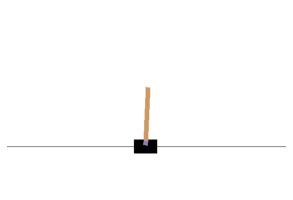

In [ ]:
plot_environment(env)
plt.show()

In [ ]:
# what are the actions from the image above? 2 = left or right
env.action_space

Discrete(2)

In [ ]:
# define action we want pole to take
action = 1 # move so that pole balances

# execute the action we want to take
obs, reward, done, info = env.step(action)
print("obs: ", obs) # new observation based on action
print("reward: ", reward) # get a reward regardless of what we do, we just want to keep the pole balanced
print("done: ", done) # when action leads to the episode being over, i.e. pole falls or if you won
print("info: ", info) # additional information the environment gives; environment specific

obs:  [-0.01261699  0.19292789  0.04204097 -0.28092127]
reward:  1.0
done:  False
info:  {}


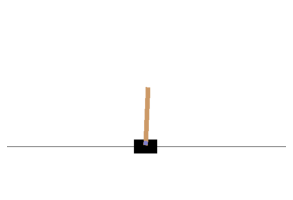

In [ ]:
plot_environment(env)
plt.show()

In [ ]:
env.close() # free resources

In [ ]:
# To get smooth animations
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def basic_policy(obs):
  """
  A simple hard coded policy that moves the
  pole in the opposite direction to what it is leaning in."""
  angle = obs[2]
  return 0 if angle < 0 else 1



frames = []
# create environment and apply policy
obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs) # apply policy 

    obs, reward, done, info = env.step(action)
    if done:
        break

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
plot_animation(frames, interval=40)

If you were to run this policy, you will find that after ~70 actions, the pole falls or moves off screen. This policy is not the best, so lets try use machine learning! 

## Neural Network Policy 

Building a neural network is fairly easy, the input are the outputs from the observation and the output of the network is effectively the action. In this case, we will have 1 output neuron which predicts the probability of taking the action left (followed by a sigmoid function to allow classes 0 or 1). 

However, the training can be difficult because we do not know about the actions we need to take in order to maximize rewards. The reward may often be delayed and sparse, making some actions not responsible for a given reward. This is where the **discount factor $\gamma$** comes in. 

In [ ]:
import tensorflow as tf
from tensorflow import keras

n_inputs = 4 # number of observations from environments

model = keras.models.Sequential([
  keras.layers.Dense(5, activation='elu', input_shape=[n_inputs]),
  keras.layers.Dense(1, activation='sigmoid')
])

### Training Neural Networks: Credit Assignment Problem


As mentioned, the discount factor is used to evaluate an action based on the actions that occured after it. The **sum of discounted rewards** is called the **action's return**. 

When the discount factor, $\gamma$, is close to zero then immediate actions will look more closely at immediate rewards; meanwhile, when closer to 1 then the future rewards will count almost as much as immediate rewards.

Typical, values are 0.99 or 0.95, a reward 13 steps into the future will count half as much the immediate rewards $0.95^{13} \approx 0.5$. To pick the right discount factor you must thing about what are the effects of an action in the short term or long term, if the later then you should opt for a higher discount factor. 

You might be thinking that some actions might be unfairly penalised. This is correct, they will. However, on average, the bad actions will return lower returns while good actions will return higher. 

## Policy Gradient

Policy gradients (PG) tries to optimize the policy to increase the rewards. It needs to explore the game for a very long time before it can start to learn what the best actions are; moreover, we are required to run multiple episodes to then estimate the advantage of each action. This is a good example of highly sample inefficient.

The PG algorithm optimizes the parameters (of a neural network for example) by following the gradient toward high rewards. The REINFORCE algorithms was introduced in 1992: 

1. Let the neural network train by playing the game, computing the gradients at each step but not applying them.

2. Calculate each action's advantage. 

3. If action's are positive these are good and they should be applied to the gradients computed to make the action even more likely to selected in the future. Multiply each action vector with the corrosponding action's advantage. 

4. Compute mean of all resulting gradient vectors to perform gradient decent step.


The `code` to create this can be found on [Ageron's Chapter 16 Notebook](https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb)

# Markov Deicison Process (MDPs)


MDP is a process when there is fixed number of states and probabilies of evolving from one state to another (i.e. fixed number of actions).  
![MDP Diagram](https://miro.medium.com/max/1400/0*hwpvyDrwZl5PkU7r)

For every action given a state we know the rewards (positive and negative) and the probability (called the transition probability). Below is a diagram that shows states in yellow circles and actions in blue diamonds alongside its transition probability and reward.  

MDP is process that highlights that the present state contains all the information neccessary to predict the future. Check out [this](https://www.coursera.org/lecture/fundamentals-of-reinforcement-learning/markov-decision-processes-8T0GQ) Coursera course to learn more about this. 
 
 <br/>

##### **Optimal State Value**
MDP provides a general framework for sequential decision making. However, the problem now is which state or action is the "best" to take to maximize the more rewards? This is where the **Bellman Optimality Equation** is used. It helps estimate the optimal state value of any state, $V^*(s)$. The value can be considered as the average reward achieved after taking an action, it is the sum of all discounted future rewards (i.e. it uses the discount factor discussed earlier). 

$V^*(s) = \max_\alpha \Sigma \space T(s, a, s')[R(s, a, s') + \gamma . V_k(s')]$

where, $T(s, a, s')$ is the transitional probability from $s$ to $s'$, $R(s, a, s')$ is the reward given the agent chose $a$ action and $\gamma$ is the discount factor.

After knowing the optimal states values, can help **evaluate** a policy, however, it does not give us the **optimal policy** for the agent. Fortunately, we can find the state-action values (also called Q-Values) by using the **Q-Value Iteration algorithm**. This formula is similiar to the $V*(s)$. 

$Q_{k+1}(s) \leftarrow \Sigma_{s'} \space T(s, a, s')[R(s, a, s') + \max Q_k(s', a')]$

This will help us determine which action the agent should take when they are in state $s$, it should choose the action with the highest Q-value.  



In [ ]:
transition_probabilities = [ # shape = [s, a, s']
          [[0.5, 0.5, 0.0], [1.0, 0.0, 0.0], [0.2, 0.8, 0.0]],
           [None, [0.8, 0.2, 0.0], [0.0, 0.0, 1.0]],
           [None, [1.0, 0.0, 0.0], None]]


rewards = [ # shape = [s, a, s']
          [[-10, -10, 0], [+20, 0, 0], [0, 0, 0]],
           [[0, 0, 0], [+40, +30, 0], [0, 0, -10]],
           [[0, 0, 0], [+100, 0, 0], [0, 0, 0]]]

possible_actions = [[0, 1, 2], [1, 2], [1]]

In [ ]:
# example, going from state 2 talking action a1 to state 0, the probability would be
transition_probabilities[2][1][0]

1.0

In [ ]:
# ditto but the reward would be 
rewards[2][1][0]

100

In [ ]:
#ditto, possible actions
possible_actions[2]

[1]

In order to find the Q-value, we need to initialize them to zero (apart from the impossible actions, which we set to zero).

In [ ]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
  Q_values[state, actions] = 0.0
Q_values # matches possible actions 

array([[  0.,   0.,   0.],
       [-inf,   0.,   0.],
       [-inf,   0., -inf]])

### Apply Q-Value Iteration Algorithm



$Q_{k+1}(s) \leftarrow \Sigma_{s'} \space T(s, a, s')[R(s, a, s') + \max Q_k(s', a')]$


In [ ]:
# discount factor
gamma = 0.95

for iteration in range(50):
  Q_prev = Q_values.copy()
  for s in range(3):
    for a in possible_actions[s]:
      Q_values[s, a] = np.sum([transition_probabilities[s][a][sp] 
                               * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp])) for sp in range(3)])

Q_values

array([[460.19986325, 473.93184952, 479.96067149],
       [        -inf, 498.43905501, 514.20250447],
       [        -inf, 553.93184952,         -inf]])

In [ ]:
np.argmax(Q_values, axis=1)

array([2, 2, 1])

Starting at state 0 (tired), the algorithm chose action sleep to state 1 (energetic), followed action gym to state 2 (healthier) then taking the only action work. The "route" effectively produced the optimal policy for this MDP.  

##### Discount Factor changes - **Life Lesson!**
If we were to decrease the discount factor ~ 0.7, then the best policy would be sleep, work and sleep

```
reduced_gamma = 0.7
np.argmax(Q_values, axis=1)

Returns: array([1, 2, 1]) # sleep work sleep
```

This highlgihts that the less value you put on future rewards (i.e. reduced discount factor) the less willing you are to put up with pain now for the promise of future rewards. Increasing gamma allows you to value more future rewards. 


### Temporal Difference Learning

In reality, we do not know what the `transition_probabilities` and `rewards` are. The agent must experience each state and transitions to know what the rewards are. The Temporal Difference Learning (TD learning) algorithm is similiar to the Value Iteration algorithm and uses an *Exploration policy** (a random policy) to explore MDP. The algorithm keeps a running track of the immediate rewards plus the rewards it expects to get later.


$V(s) \leftarrow r + \gamma .V(s')$

This is similiar to Stochastic gradient descent, where the learning rate should gradually redice as it converges to the optimal Q-value. Otherwise, it will bounce around it.  

# Q-Learning


Similiar to the Q-Value Iteration algorithm above, Q-learning is an adaption whereby we do not know the transition probabilities and rewards. The agent plays randomly and we gradually improve the Q-values by keeping track of the running average of the rewards from the state action pairs (plus the discounted rewards from future rewards). The optimal policy is the action that has the highest Q-value.

In [ ]:
# implement Q-value step

def step(state, action):
  """
  Returns the next state and reward to perform some action. 
  """
  proba = transition_probabilities[state][action]
  next_state = np.random.choice([0, 1, 2], p=proba)
  reward = rewards[state][action][next_state]
  return next_state, reward

def exploration_policy(state):
  return np.random.choice(possible_actions[state])

Lets try perform the same policy as above but without knowing the probabilities and rewards.

In [ ]:
np.random.seed(42)

# initialize Q-values 

Q_values = np.full((3, 3), -np.inf)

for state, actions in enumerate(possible_actions):
  Q_values[state][actions] = 0

# define hyperparameters
alpha0 = 0.05
decay = 0.0005
gamma = 0.9 
state = 0 # initial state
history = []

for iteration in range(20000):
  history.append(Q_values.copy())
  action = exploration_policy(state)
  next_state, reward = step(state, action)
  next_value = np.max(Q_values[next_state]) # greedy policy at the next step
  alpha = alpha0 / (1 + iteration * decay)
  Q_values[state, action] *= 1 - alpha
  Q_values[state, action] += alpha * (reward + gamma * next_value)
  state = next_state

history = np.array(history)

In [ ]:
Q_values

array([[218.55252333, 234.37537293, 238.48722404],
       [        -inf, 258.43473336, 271.97805115],
       [        -inf, 314.18381789,         -inf]])

In [ ]:
# optimal actions for each state
np.argmax(Q_values, axis=1)

array([2, 2, 1])

This matches what we had previously, however we had to do a lot more iterations because we did not know the probabilities or rewards.

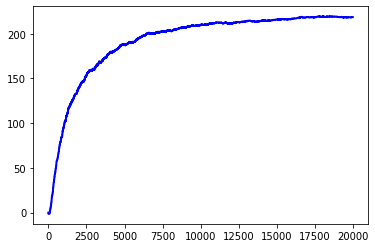

In [ ]:
plt.plot(np.arange(len(history)), history[:, 0, 0], "b-", linewidth=2)

####  Off-Policy and On-Policy Algorithms 

The Q-Learning algorithm is called an **off-policy** algorithm because the policy being trained is not neccesarily the policy being executed. This is called the exploration policy because it is completely random. While the policy being trained the optimal policy with the highest Q-values. Meanwhile, the Policy Gradient algorithm is an **on-policy** because the policy being trained is the policy being explored.


#### Exploration Policies 

We can add a hyperparameter to help only explore interesting parts of the environment. This is usally $\epsilon$, where it uses a greedy policy to spend more time exploring highest Q-value actions while still visiting unknown regions of the MDP. This approach is far better than having to randomly visit actions.

Another approach is to keep track of the number of times we try actions. We can then try actions that have not been explored much. 

$Q(s, a) \leftarrow r + \gamma . max f((Q:s', a'), N(s', a'))$

Where $N(s', a')$ is the number of times of an action that was chosen in state $s'$.

# Deep Qnetworks (DQNs)


The problem with Q-Learning is that it does not scale well. We have to keep track of all the action and state pairs, and perform them many times. If we want to be play a basic Atari game this would creep up to the order of $10^{45}$ possible states which is larger than the number of atoms on our planet. The solution is to approximate the Q-Values by finidng a function $Q_\theta(s, a)$ for any state action pair ($s, a)$ and managing number of parameters. This is called **Approximate Q Learning**.

Initially, it was thought to create handcrafted features but through DeepMind's work it became clear that using deep neural networks are far better, even with complex problems. 

- DNN is used to approximate Q-values is called a Deep Q-Network (DQN)
- Using a DQN we can approximate the Q-Learning called Deep Q-Learning. 

Training the DQN to approximate the Q-values, we know that we want the Q-value to be as close as possible to the reward after playing an action at a given state (plus the discounted value). To estimate the discounted value we execute the next state for all possible actions which gives us a future Q-value for each possible action. We then pick the highest (apply the discount factor) giving us an estimate for future rewards. 

$Q_{target}(s, a) = r + \gamma . max Q_\theta(s', a')$

The $Q_{target}$ is the target Q-value that can be used for any Gradient Descent algorithm. We want to minimize the squared error between the estimate Q-value $Q(s, a)$ and the target $Q_{target}$.

To implement a DQN we need a neural network that takes in the state and outputs one approximate Q-value for each possible action. 

In [ ]:
env = gym.make('CartPole-v0')
input_shape = [4]
n_outputs = 2

# this neural net takes in states and outputs q-value for each action
dqn_model = keras.models.Sequential([
  keras.layers.Dense(32, activation='elu', input_shape=input_shape),
  keras.layers.Dense(32, activation='elu'),
  keras.layers.Dense(n_outputs)
])

In [ ]:
def select_greedy_policy(state, epsilon=0):
  """
  Greedily selects the action with largets Q-value but still exposes
  the network to random actions.
  """
  if np.random.rand() < epsilon: return np.random.randint(n_outputs)
  else:
    Q_values = model.predict(state[np.newaxis])
    return np.argmax(Q_values[0])


We will be using the [`deque`](https://docs.python.org/3/library/collections.html#deque-objects) class within the `Collections` library, pronounced 'Deck'. Deques are generalization of stacks and queues and are O(1) performant when it comes to appending and popping from either side of the deque. They are useful for tracking data when the most recent activity is of interest. 
They are similiar to TensorFlow's [Replay Buffers](https://www.tensorflow.org/agents/tutorials/5_replay_buffers_tutorial#introduction).

Once we have the buffer we can batch them to train the agent.

![DQN Training](https://drek4537l1klr.cloudfront.net/morales/v-4/Figures/image056.jpg)


In [ ]:
from collections import deque
replay_memory = deque(maxlen=2000) # track most recent activity

Implement Deep Q-Learning


In [ ]:
def sample_experience(batch_size):
  """
  Samples a random batch from the replay buffer.
  """
  indices = np.random.randint(len(replay_memory), size=batch_size)
  batch = [replay_memory[index] for index in indices]
  states, actions, rewards, next_states, dones = [
      np.array([experience[field_index] for experience in batch]) for field_index in range(5)] # returns 5 experiences
  return states, actions, rewards, next_states, dones

In [ ]:
def play_one_step(env, state, epsilon):
  """
  Plays one step and appends into replay_memory deque.
  """
  action = select_greedy_policy(state, epsilon)
  next_state, reward, done, info = env.step(action)
  replay_memory.append((state, action, reward, next_state, done))
  return next_state, reward, done, info

In [ ]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
  """
  Takes a training step using the functions and model above.
  """
  experience = sample_experience(batch_size)
  states, actions, rewards, next_state, dones = experience
  next_Q_values = model.predict(next_state)
  max_Q_values = np.max(next_Q_values, axis=1)
  # use Target Q-value formula to find the Q-value for each state-action pair
  target_Q_values = (rewards + (1 - dones) * discount_factor * max_Q_values)
  
  # zeros out all the Q-values we do not need.
  # actions contain an array [1, 1, 0]
  # using one hot function will return [[0, 1], [0, 1], [1, 0]]
  mask = tf.one_hot(actions, n_outputs) # use this to multiply the calculation for all Q_values

  with tf.GradientTape() as tape:
    all_Q_values = model(states)
    Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
    loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
 

In [ ]:
# perform training 
rewards = []

for episode in range(600):
  obs = env.reset()
  for step in range(200):
    epsilon = max(1 - episode/ 500, 0.01)
    obs, reward, done, info = play_one_step(env, obs, epsilon)
    if done: break
  
  rewards.append(step)
  if episode > 50: training_step(batch_size) # allows replay buffer to gain a few samples


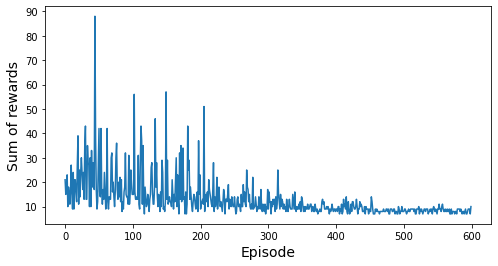

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

The RL model performs well initially but then **catestrophically forgets**. This is one of the biggest problems with RL is this forgetting of what it has learnt earlier. There are many hyperparameters that we are required to tune, such as the reply buffer size (increasing this results in may decrease the catestrophic forgetting problem), learning rate, neural network architecture etc. In reality, RL is difficult, Andrej Karpathy said, "RL must be forced to work", while "Supervised learning wants to work". 

The next step in improving RL is to modify the Q-learning algorithm to speed up training and stabilize the rewards. 

# Deep Q-Learning Variants

## Fixed Q-Value Targets

DeepMind amended the learning algorithm by changing the DQN. The problem with the current DQN was the constant feedback loop, it is learning to find the targets as well as make the predictions.

To avoid this DeepMind introduced another model, the online model, that learns at each step and moves the agent around. While the second model, the target model, defines the targets. 

```
# clone model; online and target models are the same
target = keras.models.clone(model)
target.set_weights(model.get_weights)
```

They then updated the `target` model every 50 epochs. This allows the Q-values to be more stable and prevents the oscillations we observed earlier. This dampening effect alongside a tiny learning rate, larger replay buffer (to hold more experiences), decreasing epsilon slowly and running the algorithm for more steps introduces stability within the training. By introducing these changes DeepMind was able to play Atari games. 


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=6e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experience(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

replay_memory = deque(maxlen=2000)


env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0: # set target model weights less frequently 
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 599, Steps: 182, eps: 0.010

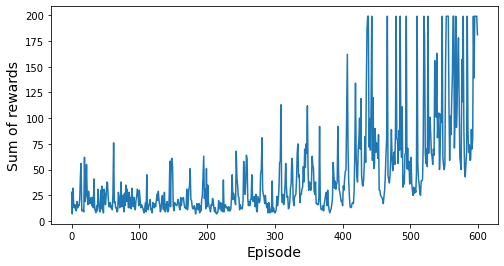

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

Better than the vanilla with a slow increase and stability on the sum of rewards.

## Double DQN

In 2015, DeepMind then tweaked their algorithm further to stabalize training and thus increasing performance, this variant was called Double DQN. The target model frequently overestimates Q-Values. 

To fix this we use online model instead of the target model to select the best actions, and using the target model to estimate the Q-values for the best actions. 

### Prioritized Experience Replay

So far, we are taking experiences from the replay buffer randomly and uniformly. Another approach could be to take a sample that are more important experiences. This idea is called **Importance Sampling (IS)** or **Experienced Replay (PER)**.

Important experiences are those that lead to fast learning, we can measure this by using the temporal difference algorithm (TD). A large TD error represents a transition that is very surprising and worth learning from. These experiences are considered very large importances. 

The issue with sampling in this way will cause the samples to be biased towards important experiences and the model will start to overfit the important experiences only. We want the important experiences to be sampled more often but we have to lower their weight during training, the authors then introduced a weight formula with several hyperparameters that controls the importance sampling bias, $w = (n P)^{-\beta}$ - where ${\beta}$=0 means no sampling bias while ${\beta}$=1 increases samplings bias entirely.   


### Dueling DQN

Another variant is the Dueling DQN, the model estimates the value of the state and advantage of each possible action. The formula used: $Q(s, a) = V(s) + A(s, a)$, where $V(s)$ is the value of the state and $A(s, a)$ is the advantage of taking the action a in state s. 

The best action should have an advantage of 0 and the model subtracts the maximum predicted advantages from all predicted advantages. 
```
raw_advantages = model(predict)
advantages = raw_advantages - max(raw_advantages, axis=1)
Q_values = state_values + advantages
```

The benefits of learning about the various variants is that they can be combined together. They tried this and called this the Rainbow technique. Rather than reinventing the wheel, you can implement the these variants by using the `TF Agents` Library. 

# TF-Agents

The [TensorFlow Agents library](https://github.com/tensorflow/agents) is a Reinforcement library that allows us to implement the variants of Q-Learning and many RL algorithms such as REINFORCE, DQN, DDQN plus more efficient memory buffers (replay buffers). 

The library has many environment and allows you to customize many components within the RL pipeline. 

- Environment Specifications: the TF-Agents library returns details about the observations, actions including their shapes, data types, names and, max and min values.

- Environment Wrappers: they are wrappers that wrap an environment. These allow you to interact with the environment 

- Training Architecture: there are many ways to do this but generally, there is a collection architecture (which interacts directly with the environment through a driver) and a training data (which stores the outcomes via the replay buffer) - this is where the nueral network and training sits. 